# Imports

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import pickle
import rasterio
import glob
import tifffile
import matplotlib.pyplot as plt
import re

# ______________________

# Healthy

## Pre-Process

### Create RGB Images

In [3]:
date_folders = sorted(glob.glob(os.path.join(lord_2_path, '*')))

for date_folder in date_folders:
    if os.path.isdir(date_folder):
        color_folders = [os.path.join(date_folder, color) for color in ['Red', 'Green', 'Blue']]
        rgb_folder = os.path.join(date_folder, 'RGB')
        os.makedirs(rgb_folder, exist_ok=True)


        tif_files = glob.glob(os.path.join(color_folders[0], '*.tif'))

        for tif_file in tif_files:
            filename = os.path.basename(tif_file)
            red_image = tifffile.imread(os.path.join(color_folders[0], filename))
            green_image = tifffile.imread(os.path.join(color_folders[1], filename))
            blue_image = tifffile.imread(os.path.join(color_folders[2], filename))

            rgb_image = np.dstack((red_image, green_image, blue_image))
            rgb_file_path = os.path.join(rgb_folder, filename)
            tifffile.imsave(rgb_file_path, rgb_image)

/var/folders/_d/jhdpffbd49j0l469jld4vbfc0000gn/T/ipykernel_9636/2468088315.py:20: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(rgb_file_path, rgb_image)


### Convert to 16bit

In [23]:
output_dir = 'Test Stitch/16bit/'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir('Test Stitch'):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        image_path = os.path.join('Test Stitch', filename)
        
        # Read the TIFF image using tifffile
        image = tifffile.imread(image_path)
        
        # Print the dtype and determine the bit depth
        image_array = np.array(image)
        dtype = image_array.dtype
        print(f"Processing {filename}")
        print(f"Image dtype: {dtype}")
        
        # Determine bit depth
        if dtype == np.uint8:
            bit_depth = 8
        elif dtype == np.uint16:
            bit_depth = 16
        elif dtype == np.float32:
            bit_depth = 32
        elif dtype == np.float64:
            bit_depth = 64
        else:
            bit_depth = "Unknown"
        
        print(f"Image bit depth: {bit_depth}")
        
        if bit_depth != 16:
            max_val = np.max(image_array)
            if max_val == 0:
                print(f"Warning: {filename} contains only zero values. Skipping normalization.")
                image_16bit_array = np.zeros_like(image_array, dtype=np.uint16)
            else:
                image_16bit_array = (image_array / max_val * 65535).astype(np.uint16)
        else:
            image_16bit_array = image_array

        print(image_16bit_array.dtype)

        
        output_filename = os.path.splitext(filename)[0] + '_16bit.tif'
        output_path = os.path.join(output_dir, output_filename)
        tifffile.imwrite(output_path, image_16bit_array)
        
        print(f"Saved 16-bit image to {output_path}")


# for filename in os.listdir('Healthy2/LORD-2/2017-02-23/Red/original'):
#     if filename.endswith('.tif') or filename.endswith('.tiff'):
#         image_path = os.path.join('Healthy2/LORD-2/2017-02-23/Red/original' + '/', filename)
#         image = Image.open(image_path)

#         mode = image.mode
#         print(f"Image mode: {mode}")

#         image_array = np.array(image)

#         dtype = image_array.dtype
#         print(f"Image dtype: {dtype}")

#         if dtype == np.uint8:
#             bit_depth = 8
#         elif dtype == np.uint16:
#             bit_depth = 16
#         elif dtype == np.float32:
#             bit_depth = 32
#         elif dtype == np.float64:
#             bit_depth = 64
#         else:
#             bit_depth = "Unknown"

#         print(f"Image bit depth: {bit_depth}")

#         image_32bit = Image.open(image_path)
#         image_array = np.array(image_32bit)
#         image_16bit_array = (image_array / np.max(image_array) * 65535).astype(np.uint16)
#         image_16bit = Image.fromarray(image_16bit_array)

#         output_filename = os.path.splitext(filename)[0] + '.tif'
#         output_path = os.path.join('Healthy2/LORD-2/2017-02-23/Red/16bit/', output_filename)
#         image_16bit.save(output_path)

Processing AMD1_Clone-A_D75_n990_r179_c13.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n990_r179_c13_16bit.tif
Processing AMD1_Clone-A_D75_n993_r179_c613.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n993_r179_c613_16bit.tif
Processing AMD1_Clone-A_D75_n991_r179_c213.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n991_r179_c213_16bit.tif
Processing AMD1_Clone-A_D75_n992_r179_c413.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n992_r179_c413_16bit.tif
Processing AMD1_Clone-A_D75_n994_r179_c813.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to Test Stitch/16bit/AMD1_Clone-A_D75_n994_r179_c813_16bit.tif
Processing AMD1_Clone-A_D75_n995_r179_c1013.tif
Image dtype: float32
Image bit depth: 32
uint16
Saved 16-bit image to

### 16bit Sanity Check

In [123]:
image_path = 'AMD/Abs Images 16bit/1A_D75_n990.tif'
image = tifffile.imread(image_path)

image_array = np.array(image)

dtype = image_array.dtype
print(f"Image dtype: {dtype}")

if dtype == np.uint8:
    bit_depth = 8
elif dtype == np.uint16:
    bit_depth = 16
elif dtype == np.float32:
    bit_depth = 32
elif dtype == np.float64:
    bit_depth = 64
else:
    bit_depth = "Unknown"

print(f"Image bit depth: {bit_depth}")

# image_path = 'Test Stitch/16bit/AMD1_Clone-A_D75_n990_r179_c13_16bit.tif'
# image = Image.open(image_path)

# mode = image.mode
# print(f"Image mode: {mode}")

# image_array = np.array(image)

# dtype = image_array.dtype
# print(f"Image dtype: {dtype}")

# if dtype == np.uint8:
#     bit_depth = 8
# elif dtype == np.uint16:
#     bit_depth = 16
# elif dtype == np.float32:
#     bit_depth = 32
# elif dtype == np.float64:
#     bit_depth = 64
# else:
#     bit_depth = "Unknown"

# print(f"Image bit depth: {bit_depth}")

Image dtype: uint16
Image bit depth: 16


## Analyze CSV

In [12]:
import csv
from statistics import mean, median, stdev

for filename in os.listdir('Healthy2/LORD-2/2017-03-02/Red/cleaned_CSVs'):
    if filename.endswith('.csv'):
        with open('Healthy2/LORD-2/2017-03-02/Red/cleaned_CSVs/'+filename, 'r') as file:
            reader = csv.DictReader(file)    
            area_values = []
            
            for row in reader:
                area_value = float(row['Area'])
                area_values.append(area_value)

            npArea = np.array(area_values)

            avg_area = mean(area_values)
            median_area = median(area_values)
            min_area = min(area_values)
            max_area = max(area_values)
            std_dev_area = stdev(area_values)

            quantiles = np.linspace(0, 1, 9)
            quantile_values = np.quantile(npArea, quantiles)

            print(f"Average of 'Area' column: {avg_area}")
            print(f"Median of 'Area' column: {median_area}")
            print(f"Minimum value in 'Area' column: {min_area}")
            print(f"Maximum value in 'Area' column: {max_area}")
            print(f"Standard deviation of 'Area' column: {std_dev_area}")
            print("q1:", quantile_values[0],
                "q2:", quantile_values[1],
                "q3:", quantile_values[2],
                "q4:", quantile_values[3],
                "q5:", quantile_values[4],
                "q6:", quantile_values[5],
                "q7:", quantile_values[6],
                "q8:", quantile_values[7],
                "q9:", quantile_values[8])


Average of 'Area' column: 118.85317164179105
Median of 'Area' column: 97.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 63.22158735203867
q1: 51.0 q2: 58.0 q3: 68.0 q4: 79.625 q5: 97.0 q6: 121.0 q7: 156.0 q8: 208.0 q9: 299.0
Average of 'Area' column: 117.37497746529655
Median of 'Area' column: 94.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 63.59087878149997
q1: 51.0 q2: 57.0 q3: 67.0 q4: 79.0 q5: 94.0 q6: 117.0 q7: 151.0 q8: 208.0 q9: 299.0
Average of 'Area' column: 112.76431174327024
Median of 'Area' column: 88.0
Minimum value in 'Area' column: 51.0
Maximum value in 'Area' column: 299.0
Standard deviation of 'Area' column: 62.165340511441826
q1: 51.0 q2: 57.0 q3: 65.0 q4: 75.0 q5: 88.0 q6: 110.0 q7: 144.0 q8: 199.0 q9: 299.0
Average of 'Area' column: 119.9970631424376
Median of 'Area' column: 97.0
Minimum value in 'Area' column: 51.0
Maximum value in

## Data Gen

### Remove NaN from csv

In [13]:
directory = '/Volumes/Samsung_T5/Healthy RGB'

for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
# for folder_name in ["LORD-4"]:
    total_cells_left = 0
    for filename in os.listdir(f"{directory}/{folder_name}_csvs"):
        if filename.endswith('.csv'):
            
            df = pd.read_csv(f"{directory}/{folder_name}_csvs/{filename}")
            before = len(df)

            df_cleaned = df.dropna()
            df_cleaned = df_cleaned[df_cleaned['Area'] < 197]  
            df_cleaned = df_cleaned[df_cleaned['Area'] > 3]  
            df_cleaned.to_csv(f"{directory}/{folder_name}_csvs_clean/{filename}", index=False)

            after = len(df_cleaned)
            total_cells_left += after

            # print(f"Length Before: {before}, Length After: {after}\nRemoved {before - after} from {filename} rows with NaN or outlier values.\n", end="\r\r\r")
            print(f"Length Before: {before}, Length After: {after}", end="\r")
    print(f"{folder_name} Remaining Cells: {total_cells_left}\n")

total_cells_left

LORD-4 Remaining Cells: 9251After: 173



9251

In [16]:
directory = '/Volumes/Samsung_T5/Healthy RGB'

for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    os.makedirs(f"{directory}/{folder_name}_csvs_thresholded", exist_ok=True)
    for filename in os.listdir(f"{directory}/{folder_name}_csvs_clean"):
        print(f"{filename}", end="\r")
        if filename.endswith('.csv'):
            
            df = pd.read_csv(f"{directory}/{folder_name}_csvs/{filename}")

            if len(df) > 15: df.to_csv(f"{directory}/{folder_name}_csvs_thresholded/{filename}", index=False)
    print(f"{folder_name}: Remaining samples: {len(os.listdir(f"{directory}/{folder_name}_csvs_thresholded"))}")

LORD-2: Remaining samples: 262
LORD-3: Remaining samples: 359
LORD-4: Remaining samples: 432
LORD-5: Remaining samples: 432
LORD-6: Remaining samples: 432
LORD-7: Remaining samples: 420


In [14]:
directory = '/Volumes/Samsung_T5/Healthy RGB'

for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    all_df = None
    for filename in os.listdir(f"{directory}/{folder_name}_csvs_clean"):
        if not filename.endswith('.csv'): pass

        df = pd.read_csv(f"{directory}/{folder_name}_csvs_clean/{filename}")
        if all_df is None: all_df = df
        else:
            all_df = pd.concat((all_df, df))

    all_df.to_csv(f"{directory}/{folder_name}_allclean", index=False)
    print(f"{folder_name} Total Cells: {len(all_df)}\n")

LORD-4 Total Cells: 9251



### Get Features Array

In [2]:
def get_features(centroid_data):

    features = centroid_data[['Area', 'Aspect_Ratio_BB', 'BB_Xmin', 'BB_Ymin', 'BB_Width', 'BB_Height', 
                              'Center_BB_X', 'Center_BB_Y', 'Centroid_X', 'Centroid_Y', 'Circularity', 
                              'Distance_From_Border', 'Eccentricity', 'Entropy', 'ExtendBB', 'Mean', 
                              'Median', 'Mode', 'Orientation', 'Perimeter', 'StandardDeviation', 
                              'Skewness', 'Kurtosis', 'Hyperskewness', 'Hyperflatness', 'TContrast_Average', 
                              'TContrast_Ortho_principal_component_value', 'TContrast_Principal_component_angle', 
                              'TContrast_Principal_component_value', 'TCorrelation_Average', 
                              'TCorrelation_Ortho_principal_component_value', 'TCorrelation_Principal_component_angle', 
                              'TCorrelation_Principal_component_value', 'THomogeneity_Average', 
                              'THomogeneity_Ortho_principal_component_value', 'THomogeneity_Principal_component_angle', 
                              'THomogeneity_Principal_component_value', 'TEnergy_Average', 
                              'TEnergy_Ortho_principal_component_value', 'TEnergy_Principal_component_angle', 
                              'TEnergy_Principal_component_value', 'TVariance_Average', 
                              'TVariance_Ortho_principal_component_value', 'TVariance_Principal_component_angle', 
                              'TVariance_Principal_component_value', 'TEntropy_Average', 
                              'TEntropy_Ortho_principal_component_value', 'TEntropy_Principal_component_angle', 
                              'TEntropy_Principal_component_value', 'TInvDiffMoment_Average', 
                              'TInvDiffMoment_Ortho_principal_component_value', 'TInvDiffMoment_Principal_component_angle', 
                              'TInvDiffMoment_Principal_component_value', 'TSumAverage_Average', 
                              'TSumAverage_Ortho_principal_component_value', 'TSumAverage_Principal_component_angle', 
                              'TSumAverage_Principal_component_value', 'TSumVariance_Average', 
                              'TSumVariance_Ortho_principal_component_value', 'TSumVariance_Principal_component_angle', 
                              'TSumVariance_Principal_component_value', 'TSumEntropy_Average', 
                              'TSumEntropy_Ortho_principal_component_value', 'TSumEntropy_Principal_component_angle', 
                              'TSumEntropy_Principal_component_value', 'TDiffAverage_Average', 
                              'TDiffAverage_Ortho_principal_component_value', 'TDiffAverage_Principal_component_angle', 
                              'TDiffAverage_Principal_component_value', 'TDiffVariance_Average', 
                              'TDiffVariance_Ortho_principal_component_value', 'TDiffVariance_Principal_component_angle', 
                              'TDiffVariance_Principal_component_value', 'TDiffEntropy_Average', 
                              'TDiffEntropy_Ortho_principal_component_value', 'TDiffEntropy_Principal_component_angle', 
                              'TDiffEntropy_Principal_component_value'

                              ]].values.astype(np.float32)

    return features

### Generate Graphs

In [5]:
directory = '/Volumes/Samsung_T5/Healthy RGB'

df_TER_y = pd.read_csv(f'{directory}/TER.csv')
df_VEGF_y = pd.read_csv(f'{directory}/VEGF.csv')
# date_folders = sorted(glob.glob(os.path.join(lord_2_path, '*')))
plate_folders = ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]


#L7_d3_C1_r1_c0.tif 
match = re.match(r"LORD-(\d+)_d(\d+)_(\w)(\d+)_r(\d)(\d)(\d)_c(\d+)(\d+)(\d+)", "LORD-7_d3_C1_r001_c000")
match.group(6)
f"L{match.group(1)}_d{match.group(2)}_{match.group(3)}{match.group(4)}_r{match.group(7)}_c{match.group(10)}.tif"

def extract_filename_structure(filename):
    date_dict = {
        "d3": "16-Feb-17",
        "d4": "23-Feb-17",
        "d5": "2-Mar-17",
        "d6": "9-Mar-17",
        "d7": "16-Mar-17",
        "d8": "23-Mar-17"
    }
    
    basename = os.path.basename(filename)
    match = re.match(r"L(\d)_d(\d)_(\w)(\d+)_r(\d)_c(\d)", basename)
    out_dict = {}
    
    out_dict["plate_name"] = f"LORD-{match.group(1)}"
    out_dict["date"] = date_dict[f"d{match.group(2)}"]
    out_dict["well"] = f"{match.group(3)}{match.group(4)}"
    return out_dict

output_filename = 'AbsImage_dataset.pkl'
num_neighbours = 20  # 10 originally

data_list = []

for folder in plate_folders:
    folder_name = f"{folder}_csvs_thresholded"
    print(f"Folder: {folder_name}")
    file_path = f"{directory}/{folder_name}"
    if os.path.isdir(file_path):
        for file in os.listdir(file_path):
            if file.endswith('.csv'):
                print("Processing file:", file, end="\r")
                centroids = pd.read_csv(f"{file_path}/{file}")

                struct_dict = extract_filename_structure(file)
                matched_TER_row = df_TER_y[(df_TER_y['well'] == struct_dict["well"]) & (df_TER_y['plate_name'] == struct_dict["plate_name"])]
                matched_VEGF_row = df_VEGF_y[(df_VEGF_y['well'] == struct_dict["well"]) & (df_VEGF_y['plate_name'] == struct_dict["plate_name"])]

                if matched_TER_row.empty or matched_TER_row[struct_dict["date"]].empty:
                    print(f"No matching TER value found for plate: {struct_dict["plate"]} well: {struct_dict["well"]} date: {struct_dict["date"]}")
                    continue
                if matched_VEGF_row.empty:
                    print(f"No matching VEGF value found for well: {struct_dict["well"]}")
                    continue

                matched_y = matched_TER_row[struct_dict["date"]].iloc[0]
                matched_ratio = matched_VEGF_row[struct_dict["date"]].iloc[0]

                # Drop unnecessary column
                if 'Partition_ID' in centroids.columns:
                    centroids = centroids.drop('Partition_ID', axis=1)

                features = get_features(centroids)

                # Create a graph
                sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
                num_nodes = len(sp_centroids)
                euc_distances = cdist(sp_centroids, sp_centroids)
                closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
                edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
                edge_index = torch.tensor(edge_array, dtype=torch.long)

                # Calculate edge weights based on distances
                closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
                edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
                edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

                edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

                data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)
                data.y = torch.tensor([matched_y, matched_ratio], dtype=torch.float)

                data_list.append(data)

with open(output_filename, 'wb') as f:
    pickle.dump(data_list, f)

print("Feature extraction and graph construction completed. Data saved to:", output_filename)


Folder: LORD-2_csvs_thresholded


KeyError: '16-Feb-17'

### Dataset Details

In [6]:
df2 = pd.read_pickle('Healthy2/AbsImage_dataset.pkl')

print(f'Number of graphs in the dataset: {len(df2)}')

for dataset in df2:
  print('----------------------')
  print(f'Data: {dataset}:')
  print(f'Number of features: {dataset.num_features}')

  print('----------------------')

  # Gather some statistics about the first graph.
  print(f'Number of nodes: {dataset.num_nodes}')
  print(f'Number of edges: {dataset.num_edges}')
  print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
  print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
  print(f'Has self-loops: {dataset.has_self_loops()}')
  print(f'Is undirected: {dataset.is_undirected()}')
  print()
  print("=====================================")

Number of graphs in the dataset: 12
----------------------
Data: Data(x=[5360, 77], edge_index=[2, 124944], edge_weights=[124944], y=[2]):
Number of features: 77
----------------------
Number of nodes: 5360
Number of edges: 124944
Average node degree: 23.31
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[5547, 77], edge_index=[2, 130113], edge_weights=[130113], y=[2]):
Number of features: 77
----------------------
Number of nodes: 5547
Number of edges: 130113
Average node degree: 23.46
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[8507, 77], edge_index=[2, 199575], edge_weights=[199575], y=[2]):
Number of features: 77
----------------------
Number of nodes: 8507
Number of edges: 199575
Average node degree: 23.46
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[5448, 77], edge_index=[2, 127308], edge_weights=[127308],

# ______________________

# AMD

## Pre-Process Cellpose

### Count Dataset

In [3]:
abs_path = '../Demonstration/QBAM_DNNS/Abs Images'
abs_label_path = '../Demonstration/QBAM_DNNS/Abs Labels'

abs_count = 0
abs_label_count = 0

for filename in os.listdir(abs_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        abs_count += 1

for filename in os.listdir(abs_label_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        abs_label_count += 1

print('Train images count:', abs_count, 'Train Labels count:', abs_label_count)

Train images count: 103 Train Labels count: 102


### Change Name for CellPose

In [4]:
"""   
For AMD Images
"""
folder_path = '../Demonstration/CellPose QBAM_DNNS/Abs Images' 
files = os.listdir(folder_path)
for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"img_{match.group(4)}.tif"
            old_file = os.path.join(folder_path, file_name)
            new_file = os.path.join(folder_path, new_name)
            os.rename(old_file, new_file)
            #print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Images completed.")



"""   
For AMD Labels
"""
folder_path2 = '../Demonstration/CellPose QBAM_DNNS/Abs Labels' 

files = os.listdir(folder_path2)

for file_name in files:
    if file_name.endswith('.tif'):
        match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
        if match:
            new_name = f"img_{match.group(4)}_masks.tif"
            old_file = os.path.join(folder_path2, file_name)
            new_file = os.path.join(folder_path2, new_name)
            os.rename(old_file, new_file)
            # print(f"Renamed: {file_name} -> {new_name}")
        else:
            print(f"Skipped: {file_name} (pattern not matched)")

print("Renaming Labels completed.")

Renaming Images completed.
Renaming Labels completed.


### Run CellPose

If no CUDA GPU, run inference on a trained model in colab: https://colab.research.google.com/drive/1z711ShE75MchIgRAZJxOm48Mi5AQSDK-#scrollTo=jlMnqge-lQ9s

If no CUDA GPU or pretrained model, train one in colab: https://colab.research.google.com/drive/1-CXFO6vhielLmazHwLlDYlFjgx0mmFF3

## Pre-Process for WIPP

### Construct Segmentations using cp_outlines.txt from cellpose

In [19]:
directory = '/Volumes/Samsung_T5/Healthy RGB/LORD-2'
count = 0
total = 0
# Iterate over all files in the directory
for filename in os.listdir(directory):
    # total+=1
    # if filename.endswith('outlines_cp_outlines.txt'):
    if filename.endswith('.npy') or filename.endswith('.png'):
        print(filename)
        os.remove(f'{directory}/{filename}')
        # count += 1
        # break

# print(count)
# print(f"Total Remaining: {total - count}")


LORD-2_d3_C1_r000_c002_outlines.png
LORD-2_d3_C1_r000_c002_seg.npy
LORD-2_d3_C1_r001_c000_outlines.png
LORD-2_d3_C1_r001_c000_seg.npy
LORD-2_d3_C1_r001_c001_outlines.png
LORD-2_d3_C1_r001_c001_seg.npy
LORD-2_d3_C1_r001_c002_outlines.png
LORD-2_d3_C1_r001_c002_seg.npy
LORD-2_d3_C1_r002_c000_outlines.png
LORD-2_d3_C1_r002_c000_seg.npy
LORD-2_d3_C1_r002_c001_outlines.png
LORD-2_d3_C1_r002_c001_seg.npy
LORD-2_d3_C1_r002_c002_outlines.png
LORD-2_d3_C1_r002_c002_seg.npy
LORD-2_d3_C1_r003_c000_outlines.png
LORD-2_d3_C1_r003_c000_seg.npy
LORD-2_d3_C1_r003_c001_outlines.png
LORD-2_d3_C1_r003_c001_seg.npy
LORD-2_d3_C1_r003_c002_outlines.png
LORD-2_d3_C1_r003_c002_seg.npy
LORD-2_d3_C2_r000_c000_outlines.png
LORD-2_d3_C2_r000_c000_seg.npy
LORD-2_d3_C2_r000_c001_outlines.png
LORD-2_d3_C2_r000_c001_seg.npy
LORD-2_d3_C2_r000_c002_outlines.png
LORD-2_d3_C2_r000_c002_seg.npy
LORD-2_d3_C2_r001_c000_outlines.png
LORD-2_d3_C2_r001_c000_seg.npy
LORD-2_d3_C2_r001_c001_outlines.png
LORD-2_d3_C2_r001_c001_seg

In [10]:
def process_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    coordinates = [list(map(int, line.split(','))) for line in data.split('\n') if line]
    max_x = max(coord[0] for line in coordinates for coord in zip(line[::2], line[1::2]))
    max_y = max(coord[1] for line in coordinates for coord in zip(line[::2], line[1::2]))
    image = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)

    for line in coordinates:
        for i in range(0, len(line) - 3, 2):
            x1, y1, x2, y2 = line[i:i+4]
            rr, cc = np.array([y1, y2]), np.array([x1, x2])
            rr, cc = np.clip(rr, 0, max_y), np.clip(cc, 0, max_x)
            image[rr, cc] = 255

    output_file_path = file_path.replace('_cp_outlines.txt', '.tif')
    tifffile.imwrite(output_file_path, image)
    os.remove(file_path)
    print(f"Image saved as '{output_file_path}' and original file deleted.")

directory = '/Volumes/Samsung_T5/Healthy RGB'

# Iterate over all files in the directory
for folder in ["LORD-4"]:
    for filename in os.listdir(f"{directory}/{folder}_outlines"):
        if filename.endswith('_cp_outlines.txt'):
            process_file(f"{directory}/{folder}_outlines/{filename}")




Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r000_c000.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r000_c001.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r000_c002.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r001_c000.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r001_c001.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r001_c002.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r002_c000.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/LORD-4_outlines/LORD-4_d3_B1_r002_c001.tif' and original file deleted.
Image saved as '/Volumes/Samsung_T5/Healthy RGB/

### Sanity Check Construction

In [35]:
sample = tifffile.imread('../../Data/CellPose Segmentations/images/1A_D75_n990.tif')
sample

array([[[0.13580996, 0.15661162, 0.1941583 ],
        [0.1732887 , 0.19431183, 0.2562898 ],
        [0.18677455, 0.21782406, 0.28676876],
        ...,
        [0.05643614, 0.08520766, 0.09153288],
        [0.05818316, 0.08242196, 0.08654027],
        [0.05981352, 0.07955567, 0.08998889]],

       [[0.1315417 , 0.14697815, 0.18123081],
        [0.16269277, 0.17362668, 0.23064108],
        [0.16178757, 0.19234768, 0.24351767],
        ...,
        [0.05343024, 0.07808753, 0.08113299],
        [0.05328023, 0.07496607, 0.08104251],
        [0.05331599, 0.07386743, 0.07840847]],

       [[0.10587943, 0.13263682, 0.15158877],
        [0.12709323, 0.14082375, 0.17837639],
        [0.12817833, 0.15302512, 0.1849846 ],
        ...,
        [0.05282099, 0.07315887, 0.07619239],
        [0.05267505, 0.07219569, 0.07460432],
        [0.05330876, 0.07090299, 0.07246553]],

       ...,

       [[0.11852682, 0.17204088, 0.18191384],
        [0.12316348, 0.15848024, 0.16718528],
        [0.1479887 , 0

In [36]:
red_image = tifffile.imread('/Users/bumjin/Downloads/B1_r000_c000 (5).tif')
blue_image = tifffile.imread('/Users/bumjin/Downloads/B1_r000_c000 (3).tif')
green_image = tifffile.imread('/Users/bumjin/Downloads/B1_r000_c000 (4).tif')
rgb_image = np.dstack((red_image, green_image, blue_image))
rgb_image

array([[[0.29169437, 0.4068285 , 0.32298678],
        [0.30200693, 0.4077239 , 0.33229858],
        [0.28814197, 0.4051762 , 0.3327869 ],
        ...,
        [0.12403291, 0.21053609, 0.12357624],
        [0.12532733, 0.20816396, 0.12078543],
        [0.1288469 , 0.21596141, 0.12302171]],

       [[0.27423632, 0.39589792, 0.31311983],
        [0.3060583 , 0.41049814, 0.33731368],
        [0.3174067 , 0.41699487, 0.33665794],
        ...,
        [0.13476208, 0.21869573, 0.13336912],
        [0.13701062, 0.21582769, 0.12802301],
        [0.1341408 , 0.22201353, 0.1285581 ]],

       [[0.24636072, 0.36666405, 0.3128584 ],
        [0.28698877, 0.39672798, 0.3287013 ],
        [0.32747275, 0.4262217 , 0.33954525],
        ...,
        [0.14801669, 0.22761397, 0.14356774],
        [0.14948168, 0.23117182, 0.14019273],
        [0.14851527, 0.23405309, 0.13688973]],

       ...,

       [[0.16282551, 0.24765417, 0.14627378],
        [0.21386978, 0.28981128, 0.18744986],
        [0.25417042, 0

In [45]:
parent_dir = "/Volumes/Samsung_T5/Healthy RGB"
for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    print(f"Folder: {folder_name}\n")
    for filename in os.listdir(f'{parent_dir}/{folder_name}'):
        print(f"\nFile: {filename}", end="\r")
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            image_path = f"/Volumes/Samsung_T5/Healthy RGB/{folder_name}/{filename}"
            image = tifffile.imread(image_path)

            dtype = image.dtype
            # print(f"Image dtype: {dtype}")

            assert dtype == np.uint16
            
            image = (image / 65535).astype(np.float32)

            output_path = os.path.join(f'{parent_dir}/{folder_name}_float', filename)
            tifffile.imwrite(output_path, image)

Folder: LORD-2

Folder: LORD-36_C4_r003_c002.tif

Folder: LORD-48_C4_r003_c002.tif

Folder: LORD-58_C4_r003_c002.tif

Folder: LORD-68_C4_r003_c002.tif

Folder: LORD-78_C4_r003_c002.tif



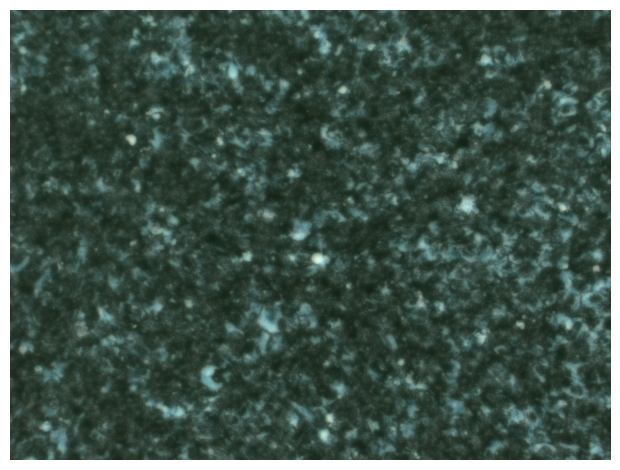

In [40]:
image = tifffile.imread('/Users/bumjin/Downloads/LORD-7_d6_C3_r003_c002.tif')
image = (image / 65535).astype(np.float32)
fig, ax = plt.subplots()
ax.imshow(image)

plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
image.dtype

dtype('uint16')

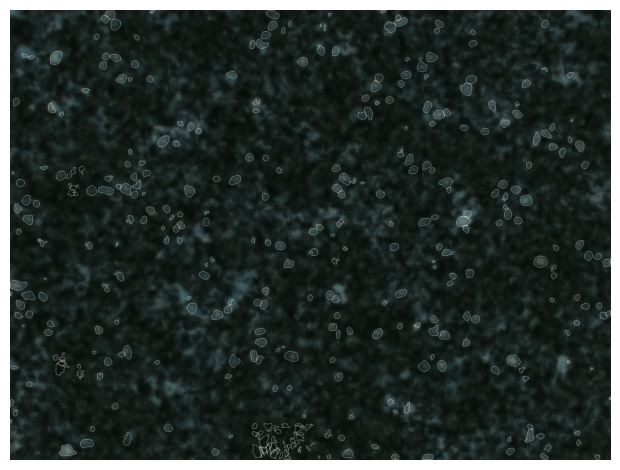

In [52]:
image = tifffile.imread('/Volumes/Samsung_T5/Healthy RGB/LORD-7_float/LORD-7_d3_B1_r000_c000.tif')
label = tifffile.imread('/Volumes/Samsung_T5/Healthy RGB/LORD-7_outlines/LORD-7_d3_B1_r000_c000.tif')

# Convert image2 to RGBA if it's not
if len(label.shape) == 2:
    label = np.stack((label,)*3, axis=-1)
    label = np.dstack((label, np.full_like(label[:, :, 0], 128)))  # Add alpha channel
else:
    label = np.dstack((label, np.full_like(label[:, :, 0], 128)))  # Add alpha channel

# Normalize image2 to have values between 0 and 1
label = label.astype(float) / 255

# Overlay the images
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(label, alpha=1)  # Make image2 semi-transparent

# Save the figure
# fig.savefig('overlay.png', dpi=300)

# Display the result
plt.axis('off')
plt.tight_layout()
plt.show()

# print("Overlay image saved as 'overlay.png'")

### Change Name for WIPP

In [72]:
match = re.match(r"LORD-(\d+)_d(\d+)_(\w)(\d+)_r(\d)(\d)(\d)_c(\d+)(\d+)(\d+)", "LORD-7_d3_C1_r001_c000")
match.group(6)
f"L{match.group(1)}_d{match.group(2)}_{match.group(3)}{match.group(4)}_r{match.group(7)}_c{match.group(10)}.tif"

'L7_d3_C1_r1_c0.tif'

In [12]:
parent_dir = "/Volumes/Samsung_T5/Healthy RGB"
for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    folder_path = f'{parent_dir}/{folder_name}_float' 
    files = os.listdir(folder_path)

    for file_name in files:
        if file_name.endswith('.tif'):
            match = re.match(r"LORD-(\d+)_d(\d+)_(\w)(\d+)_r(\d+)(\d+)(\d+)_c(\d+)(\d+)(\d+)", file_name)
            if match:
                # new_name = f"{match.group(1)}{match.group(2)}_D{match.group(3)}_n{match.group(4)}.tif"
                new_name = f"L{match.group(1)}_d{match.group(2)}_{match.group(3)}{match.group(4)}_r{match.group(7)}_c{match.group(10)}.tif"
                old_file = os.path.join(folder_path, file_name)
                new_file = os.path.join(folder_path, new_name)
                os.rename(old_file, new_file)
                # print(f"Renamed: {file_name} -> {new_name}")
            else:
                print(f"Skipped: {file_name} (pattern not matched)")

    print("Renaming Images completed.")

    folder_path = f'{parent_dir}/{folder_name}_outlines' 
    files = os.listdir(folder_path)

    for file_name in files:
        if file_name.endswith('.tif'):
            # match = re.match(r"AMD(\d+)_Clone-(\w+)_D(\d+)_n(\d+)", file_name)
            match = re.match(r"LORD-(\d+)_d(\d+)_(\w)(\d+)_r(\d+)(\d+)(\d+)_c(\d+)(\d+)(\d+)", file_name)
            if match:
                new_name = f"L{match.group(1)}_d{match.group(2)}_{match.group(3)}{match.group(4)}_r{match.group(7)}_c{match.group(10)}.tif"
                old_file = os.path.join(folder_path, file_name)
                new_file = os.path.join(folder_path, new_name)
                os.rename(old_file, new_file)
                # print(f"Renamed: {file_name} -> {new_name}")
            else:
                print(f"Skipped: {file_name} (pattern not matched)")

    print("Renaming Labels completed.")

Renaming Labels completed.


### Count Matches

In [87]:
# Define your source directories
# image_source_dir = '../Demonstration/WIPP QBAM_DNNS/Abs Images'
# label_source_dir = '../Demonstration/WIPP QBAM_DNNS/Abs Labels'
parent_dir = "/Volumes/Samsung_T5/Healthy RGB"
for folder_name in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    print(folder_name)
    image_source_dir = f'{parent_dir}/{folder_name}_float' 
    label_source_dir = f'{parent_dir}/{folder_name}_outlines' 

    # Get the list of all files in the source directories
    image_files = set(os.listdir(image_source_dir))
    label_files = set(os.listdir(label_source_dir))

    # Find the matches
    matches = image_files.intersection(label_files)
    # Print the number of matches
    print(f'Number of matches: {len(matches)}')

    # Find the files that don't match
    non_matches = image_files.symmetric_difference(label_files)
    # Print the names of the non-matching files
    print('Non-matches: ', len(non_matches), non_matches)

LORD-2
Number of matches: 262
Non-matches:  0 set()
LORD-3
Number of matches: 359
Non-matches:  1 {'L3_d8_C4_r3_c2.tif'}
LORD-4
Number of matches: 282
Non-matches:  151 {'L4_d5_C1_r1_c0.tif', 'L4_d6_C2_r1_c0.tif', 'L4_d5_C4_r3_c1.tif', 'L4_d6_B1_r3_c1.tif', 'L4_d5_C1_r2_c1.tif', 'L4_d6_C4_r1_c0.tif', 'L4_d6_C2_r0_c0.tif', 'L4_d5_C3_r1_c1.tif', 'L4_d6_C2_r3_c1.tif', 'L4_d5_C1_r1_c1.tif', 'L4_d5_B1_r3_c1.tif', 'L4_d6_C1_r1_c1.tif', 'L4_d6_C4_r0_c1.tif', 'L4_d5_C1_r3_c0.tif', 'L4_d6_C4_r0_c0.tif', 'L4_d6_B1_r3_c0.tif', 'L4_d5_B2_r2_c1.tif', 'L4_d6_C1_r1_c2.tif', 'L4_d5_C2_r1_c0.tif', 'L4_d5_C4_r1_c2.tif', 'L4_d6_B1_r0_c2.tif', 'L4_d5_C1_r2_c0.tif', 'L4_d6_C2_r3_c2.tif', 'L4_d5_B2_r1_c0.tif', 'L4_d5_C3_r2_c0.tif', 'L4_d5_C2_r2_c2.tif', 'L4_d7_B1_r1_c2.tif', 'L4_d6_B1_r2_c0.tif', 'L4_d5_B2_r0_c0.tif', 'L4_d5_B2_r3_c0.tif', 'L4_d5_C3_r3_c0.tif', 'L4_d5_B2_r2_c2.tif', 'L4_d5_C1_r0_c2.tif', 'L4_d6_B2_r2_c2.tif', 'L4_d6_C1_r2_c0.tif', 'L4_d5_C3_r1_c0.tif', 'L4_d5_B1_r2_c1.tif', 'L4_d6_B2_r0_c1.

## Analyze CSV

In [88]:
import csv
from statistics import mean, median, stdev

with open('/Volumes/Samsung_T5/Healthy RGB/LORD-7_csvs/L7_d3_B1_r0_c0.ome.tif.csv', 'r') as file:
    reader = csv.DictReader(file)    
    area_values = []
    
    for row in reader:
        area_value = float(row['Area'])
        area_values.append(area_value)

    npArea = np.array(area_values)

    avg_area = mean(area_values)
    median_area = median(area_values)
    min_area = min(area_values)
    max_area = max(area_values)
    std_dev_area = stdev(area_values)

    quantiles = np.linspace(0, 1, 9)
    quantile_values = np.quantile(npArea, quantiles)

    print(f"Average of 'Area' column: {avg_area}")
    print(f"Median of 'Area' column: {median_area}")
    print(f"Minimum value in 'Area' column: {min_area}")
    print(f"Maximum value in 'Area' column: {max_area}")
    print(f"Standard deviation of 'Area' column: {std_dev_area}")
    print("Below are 9 'Area' quantiles:")
    print("q1:", quantile_values[0],
          "q2:", quantile_values[1],
          "q3:", quantile_values[2],
          "q4:", quantile_values[3],
          "q5:", quantile_values[4],
          "q6:", quantile_values[5],
          "q7:", quantile_values[6],
          "q8:", quantile_values[7],
          "q9:", quantile_values[8])


Average of 'Area' column: 2.8935153583617748
Median of 'Area' column: 2.0
Minimum value in 'Area' column: 1.0
Maximum value in 'Area' column: 197.0
Standard deviation of 'Area' column: 4.113668132368358
Below are 9 'Area' quantiles:
q1: 1.0 q2: 1.0 q3: 1.0 q4: 2.0 q5: 2.0 q6: 2.0 q7: 3.0 q8: 5.0 q9: 197.0


## GNN Data Gen

### Remove NaN from csv

In [25]:
for folder in ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]:
    folder_path = f'/Volumes/Samsung_T5/Healthy RGB/{folder}_csvs'
    out_path = f'/Volumes/Samsung_T5/Healthy RGB/{folder}_csvs_thresholded'

    print(f"Folder: {folder_path}")
    # all = 0
    # total_3 = 0
    # total_10 = 0
    # total_15 = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(f'{folder_path}/{file_name}')
            before = len(df)
            df_cleaned = df.dropna()
            # all += 1

            df_cleaned = df_cleaned[df_cleaned['Area'] < 197]
            # df_cleaned = df_cleaned[df_cleaned['Area'] > 3]  
            # if len(df_cleaned) > 30: total_3 += 1

            # df_cleaned = df_cleaned[df_cleaned['Area'] > 10]  
            # if len(df_cleaned) > 30: total_10 += 1

            df_cleaned = df_cleaned[df_cleaned['Area'] > 15]  
            # if len(df_cleaned) > 30: total_15 += 1

            if len(df_cleaned) > 30:
                df_cleaned.to_csv(f'{out_path}' + '/' + f'{file_name}', index=False)

    # print(f"  Before: {all}\n  Remaining 3s: {total_3}\n  Remaining 10s: {total_10}\n  Remaining 15s: {total_15}")

Folder: /Volumes/Samsung_T5/Healthy RGB/LORD-6_csvs


In [4]:
for folder in ["LORD-2", "LORD-3", "LORD-5", "LORD-6", "LORD-7"]:
    folder_path = f'/Volumes/Samsung_T5/Healthy RGB/{folder}_csvs'

    out_path = f'/Volumes/Samsung_T5/Healthy RGB/{folder}_csvs_clean'

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(f'{folder_path}/{file_name}')
            before = len(df)
            print("Length Before: ", before)

            df_cleaned = df.dropna()
            df_cleaned = df_cleaned[df_cleaned['Area'] < 197]  
            df_cleaned = df_cleaned[df_cleaned['Area'] > 15]

            
            after = len(df_cleaned)
            print("Length After: ", after)

            if after > 30:
                df_cleaned.to_csv(f'{out_path}' + '/' + f'{file_name}', index=False)

            print(f"Removed {before - after} Rows with NaN or outlier values.")

# input_path = 'Dataset'

# for folder in os.listdir(input_path):

#     folder_path = input_path + '/' + folder + '/Test'
#     out_path = input_path + '/' + folder + '/cleaned test'

#     for file_name in os.listdir(folder_path):
#         if file_name.endswith('.csv'):
#             df = pd.read_csv(f'{folder_path}/{file_name}')
#             before = len(df)
#             print("Length Before: ", before)

#             df_cleaned = df.dropna()
#             df_cleaned = df_cleaned[df_cleaned['Area'] < 500]  
#             df_cleaned = df_cleaned[df_cleaned['Area'] > 150]

            
#             df_cleaned.to_csv(f'{out_path}' + '/' + f'{file_name}', index=False)

#             after = len(df_cleaned)
#             print("Length After: ", after)


#             print(f"Removed {before - after} Rows with NaN or outlier values.")

Length Before:  5963
Length After:  7
Removed 5956 Rows with NaN or outlier values.
Length Before:  6881
Length After:  12
Removed 6869 Rows with NaN or outlier values.
Length Before:  7700
Length After:  11
Removed 7689 Rows with NaN or outlier values.
Length Before:  6397
Length After:  7
Removed 6390 Rows with NaN or outlier values.
Length Before:  6934
Length After:  10
Removed 6924 Rows with NaN or outlier values.
Length Before:  7981
Length After:  9
Removed 7972 Rows with NaN or outlier values.
Length Before:  7607
Length After:  15
Removed 7592 Rows with NaN or outlier values.
Length Before:  8078
Length After:  17
Removed 8061 Rows with NaN or outlier values.
Length Before:  6370
Length After:  4
Removed 6366 Rows with NaN or outlier values.
Length Before:  7717
Length After:  21
Removed 7696 Rows with NaN or outlier values.
Length Before:  12643
Length After:  35
Removed 12608 Rows with NaN or outlier values.
Length Before:  12175
Length After:  46
Removed 12129 Rows with NaN

### Get Features Array

In [9]:
def get_features(centroid_data):

    features = centroid_data[['Area', 'Aspect_Ratio_BB', 'BB_Xmin', 'BB_Ymin', 'BB_Width', 'BB_Height', 
                              'Center_BB_X', 'Center_BB_Y', 'Centroid_X', 'Centroid_Y', 'Circularity', 
                              'Distance_From_Border', 'Eccentricity', 'Entropy', 'ExtendBB', 'Mean', 
                              'Median', 'Mode', 'Orientation', 'Perimeter', 'StandardDeviation', 
                              'Skewness', 'Kurtosis', 'Hyperskewness', 'Hyperflatness', 'TContrast_Average', 
                              'TContrast_Ortho_principal_component_value', 'TContrast_Principal_component_angle', 
                              'TContrast_Principal_component_value', 'TCorrelation_Average', 
                              'TCorrelation_Ortho_principal_component_value', 'TCorrelation_Principal_component_angle', 
                              'TCorrelation_Principal_component_value', 'THomogeneity_Average', 
                              'THomogeneity_Ortho_principal_component_value', 'THomogeneity_Principal_component_angle', 
                              'THomogeneity_Principal_component_value', 'TEnergy_Average', 
                              'TEnergy_Ortho_principal_component_value', 'TEnergy_Principal_component_angle', 
                              'TEnergy_Principal_component_value', 'TVariance_Average', 
                              'TVariance_Ortho_principal_component_value', 'TVariance_Principal_component_angle', 
                              'TVariance_Principal_component_value', 'TEntropy_Average', 
                              'TEntropy_Ortho_principal_component_value', 'TEntropy_Principal_component_angle', 
                              'TEntropy_Principal_component_value', 'TInvDiffMoment_Average', 
                              'TInvDiffMoment_Ortho_principal_component_value', 'TInvDiffMoment_Principal_component_angle', 
                              'TInvDiffMoment_Principal_component_value', 'TSumAverage_Average', 
                              'TSumAverage_Ortho_principal_component_value', 'TSumAverage_Principal_component_angle', 
                              'TSumAverage_Principal_component_value', 'TSumVariance_Average', 
                              'TSumVariance_Ortho_principal_component_value', 'TSumVariance_Principal_component_angle', 
                              'TSumVariance_Principal_component_value', 'TSumEntropy_Average', 
                              'TSumEntropy_Ortho_principal_component_value', 'TSumEntropy_Principal_component_angle', 
                              'TSumEntropy_Principal_component_value', 'TDiffAverage_Average', 
                              'TDiffAverage_Ortho_principal_component_value', 'TDiffAverage_Principal_component_angle', 
                              'TDiffAverage_Principal_component_value', 'TDiffVariance_Average', 
                              'TDiffVariance_Ortho_principal_component_value', 'TDiffVariance_Principal_component_angle', 
                              'TDiffVariance_Principal_component_value', 'TDiffEntropy_Average', 
                              'TDiffEntropy_Ortho_principal_component_value', 'TDiffEntropy_Principal_component_angle', 
                              'TDiffEntropy_Principal_component_value'

                              ]].values.astype(np.float32)

    return features

### Generate Graphs

In [76]:
import os
import pandas as pd

dfs = {}

for dtype in ["TER", "VEGF"]:
    df_y = pd.read_csv(f'GNN Label CSVs/AMD_{dtype}_Data.csv')
    dfs[dtype] = df_y

for df_key in dfs:
    df = dfs[df_key]
    df['Title'] = df.apply(lambda row: f"{row['clone']}{row['day']}", axis=1)
    dfs[df_key] = df

def extract_clone_day_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split('_')
    clone = parts[0]  # Example: '1A'
    day = parts[1][1:]    # Example: 'D75'
    return clone, day

bin_count = {}

scanned = 0
for split in ["Train", "Test", "Valid"]:
    centroids_filepath = f'../../Data/CellPose Segmentations/clean/{split}'
    for file in os.listdir(centroids_filepath):
        scanned += 1
        if file.endswith('.csv'):
            clone, day = extract_clone_day_from_filename(file)
            title = f"{clone}{day}"
            if title in bin_count:
                bin_count[title] += 1
            else:
                bin_count[title] = 1
        # else: print(f"Non-match: {file}")


sum_bin_files = 0
for key in bin_count:
    print(f"Bin Name: {key}, Count: {bin_count[key]}")
    sum_bin_files += bin_count[key]

print(f"Scanned {scanned}, Found {sum_bin_files} bins")

for df_key in dfs:
    df = dfs[df_key]
    label_bins = df["Title"].unique()
    # print(f"Label Bins: {label_bins}")
    for bin in label_bins:
        if df_key == "VEGF": bin = bin[0:2] + bin[3:]
        if bin not in bin_count:
            print(f"{df_key} Label Bin {bin} missing from files")
        

Bin Name: 1B74, Count: 86
Bin Name: 3B73, Count: 149
Bin Name: 3B74, Count: 144
Bin Name: 1B75, Count: 94
Bin Name: 1A75, Count: 109
Bin Name: 3C75, Count: 151
Bin Name: 1B76, Count: 161
Bin Name: 1B73, Count: 1
Bin Name: 2B73, Count: 64
Bin Name: 1B77, Count: 71
Scanned 1033, Found 1030 bins
TER Label Bin 2A75 missing from files
TER Label Bin 2B74 missing from files
TER Label Bin 2B75 missing from files
TER Label Bin 2B76 missing from files
TER Label Bin 2B77 missing from files
TER Label Bin 2C75 missing from files
TER Label Bin 3A75 missing from files
TER Label Bin 3B75 missing from files
TER Label Bin 3B76 missing from files
TER Label Bin 3B77 missing from files
VEGF Label Bin 2A75 missing from files
VEGF Label Bin 2B75 missing from files
VEGF Label Bin 2B77 missing from files
VEGF Label Bin 2C75 missing from files
VEGF Label Bin 3A75 missing from files
VEGF Label Bin 3B75 missing from files
VEGF Label Bin 3B77 missing from files


In [23]:
directory = '/Volumes/Samsung_T5/Healthy RGB'

df_TER_y = pd.read_csv(f'{directory}/TER.csv')
df_VEGF_y = pd.read_csv(f'{directory}/VEGF.csv')
# plate_folders = ["LORD-2", "LORD-3", "LORD-4", "LORD-5", "LORD-6", "LORD-7"]
plate_folders = ["LORD-6", "LORD-7"]

def extract_filename_structure(filename):
    date_dict = {
        "d3": "16-Feb-17",
        "d4": "23-Feb-17",
        "d5": "2-Mar-17",
        "d6": "9-Mar-17",
        "d7": "16-Mar-17",
        "d8": "23-Mar-17"
    }
    
    basename = os.path.basename(filename)
    match = re.match(r"L(\d)_d(\d)_(\w)(\d+)_r(\d)_c(\d)", basename)
    out_dict = {}
    
    out_dict["plate_name"] = f"LORD-{match.group(1)}"
    out_dict["date"] = date_dict[f"d{match.group(2)}"]
    out_dict["well"] = f"{match.group(3)}{match.group(4)}"
    return out_dict

# output_filename = 'AbsImage_dataset.pkl'
num_neighbours = 20  # 10 originally

data_list = []

for folder in plate_folders:
    folder_name = f"{folder}_csvs_thresholded"
    print(f"Folder: {folder_name}")
    output_filename = f'AbsImage_dataset_{folder}.pkl'
    file_path = f"{directory}/{folder_name}"
    if os.path.isdir(file_path):
        for file in os.listdir(file_path):
            if file.endswith('.csv'):
                print("Processing file:", file, end="\r")
                centroids = pd.read_csv(f"{file_path}/{file}")

                struct_dict = extract_filename_structure(file)
                matched_TER_row = df_TER_y[(df_TER_y['well'] == struct_dict["well"]) & (df_TER_y['plate_name'] == struct_dict["plate_name"])]
                matched_VEGF_row = df_VEGF_y[(df_VEGF_y['well'] == struct_dict["well"]) & (df_VEGF_y['plate_name'] == struct_dict["plate_name"])]

                if matched_TER_row.empty or struct_dict["date"] not in matched_TER_row.columns:
                    # print(f"No matching TER value found for plate: {struct_dict["plate_name"]}, well: {struct_dict["well"]}, date: {struct_dict["date"]}", end="\r")
                    continue
                if matched_VEGF_row.empty or struct_dict["date"] not in matched_VEGF_row.columns:
                    # print(f"No matching VEGF value found for plate: {struct_dict["plate_name"]}, well: {struct_dict["well"]}, date: {struct_dict["date"]}", end="\r")
                    continue


                matched_y = matched_TER_row[struct_dict["date"]].iloc[0]
                matched_ratio = matched_VEGF_row[struct_dict["date"]].iloc[0]

                # Drop unnecessary column
                if 'Partition_ID' in centroids.columns:
                    centroids = centroids.drop('Partition_ID', axis=1)

                features = get_features(centroids)

                # Create a graph
                sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
                num_nodes = len(sp_centroids)
                euc_distances = cdist(sp_centroids, sp_centroids)
                closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
                edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
                edge_index = torch.tensor(edge_array, dtype=torch.long)

                # Calculate edge weights based on distances
                closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
                edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
                edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

                edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

                data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)
                data.y = torch.tensor([matched_y, matched_ratio], dtype=torch.float)

                data_list.append(data)

    with open(f"{directory}/{output_filename}", 'wb') as f:
        pickle.dump(data_list, f)

    print("Feature extraction and graph construction completed. Data saved to:", output_filename)


Folder: LORD-6_csvs_thresholded
Feature extraction and graph construction completed. Data saved to: AbsImage_dataset_LORD-6.pkl
Folder: LORD-7_csvs_thresholded
Feature extraction and graph construction completed. Data saved to: AbsImage_dataset_LORD-7.pkl


In [26]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import pickle

directory = '/Volumes/Samsung_T5/Healthy RGB'

dfs = {}
for dtype in ["TER", "VEGF"]:
    df_y = pd.read_csv(f'{directory}/{dtype}.csv')
    dfs[dtype] = df_y

num_neighbours = 20

def extract_filename_structure(filename):
    date_dict = {
        "d3": "16-Feb-17",
        "d4": "23-Feb-17",
        "d5": "2-Mar-17",
        "d6": "9-Mar-17",
        "d7": "16-Mar-17",
        "d8": "23-Mar-17"
    }
    
    basename = os.path.basename(filename)
    match = re.match(r"L(\d)_d(\d)_(\w)(\d+)_r(\d)_c(\d)", basename)
    out_dict = {}
    
    out_dict["plate_name"] = f"LORD-{match.group(1)}"
    out_dict["date"] = date_dict[f"d{match.group(2)}"]
    out_dict["well"] = f"{match.group(3)}{match.group(4)}"
    return out_dict

count = 0
not_added = 0

train_folders = ["LORD-3", "LORD-4", "LORD-5", "LORD-6"]
valid_folders = ["LORD-2"]
test_folders = ["LORD-7"]
plate_folders = {"Train": train_folders, "Valid": valid_folders, "Test":test_folders}

for data_type in ["TER", "VEGF", "Both"]:
    print(f"Data Type: {data_type}")
    if data_type != "Donor":
        dtype_list = ["TER", "VEGF"] if data_type == "Both" else [f"{data_type}"]
    for split in ["Train", "Valid", "Test"]:
        print(f"   Split: {split}")
        output_filename = f'{directory}/{split}_{data_type}.pkl'
        data_list = []
        for folder in plate_folders[split]:
            folder_name = f"{folder}_csvs_thresholded"
            print(f"Folder: {folder_name}")
            centroids_filepath = f"{directory}/{folder_name}"
            for file in os.listdir(centroids_filepath):
                if file.endswith('.csv'):
                    file_path = os.path.join(centroids_filepath, file)
                    # print("Processing file:", file)

                    centroids = pd.read_csv(file_path)

                    struct_dict = extract_filename_structure(file)
                    
                    if "TER" in dtype_list:
                        matched_TER_row = df_TER_y[(df_TER_y['well'] == struct_dict["well"]) & (df_TER_y['plate_name'] == struct_dict["plate_name"])]

                        if matched_TER_row.empty or struct_dict["date"] not in matched_TER_row.columns:
                            # print(f"No matching TER value found for plate: {struct_dict["plate_name"]}, well: {struct_dict["well"]}, date: {struct_dict["date"]}", end="\r")
                            continue

                        matched_TER = matched_TER_row[struct_dict["date"]].iloc[0]
                    
                    if "VEGF" in dtype_list:
                        matched_VEGF_row = df_VEGF_y[(df_VEGF_y['well'] == struct_dict["well"]) & (df_VEGF_y['plate_name'] == struct_dict["plate_name"])]

                        if matched_VEGF_row.empty or struct_dict["date"] not in matched_VEGF_row.columns:
                            # print(f"No matching VEGF value found for plate: {struct_dict["plate_name"]}, well: {struct_dict["well"]}, date: {struct_dict["date"]}", end="\r")
                            continue

                        matched_VEGF = matched_VEGF_row[struct_dict["date"]].iloc[0]

                    if 'Partition_ID' in centroids.columns:
                        centroids = centroids.drop('Partition_ID', axis=1)

                    features = get_features(centroids)

                    sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
                    num_nodes = len(sp_centroids)
                    euc_distances = cdist(sp_centroids, sp_centroids)
                    closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
                    edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
                    edge_index = torch.tensor(edge_array, dtype=torch.long)

                    closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
                    edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
                    edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

                    edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

                    data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)

                    output_list = []
                    if data_type == "Donor":
                        one_hot = [0,0,0]
                        one_hot[int(clone[0]) - 1] = 1
                        output_list = one_hot
                    else:
                        if "VEGF" in dtype_list:
                            output_list.append(matched_VEGF)
                        if "TER" in dtype_list:
                            output_list.append(matched_TER)

                    data.y = torch.tensor(output_list, dtype=torch.float)
                    count += 1
                    data_list.append(data)
        print("added ", count)
        print("Couldnt add", not_added)

        print(data_list)

        with open(output_filename, 'wb') as f:
            pickle.dump(data_list, f)

        print("Dataset construction completed. Data saved to:", output_filename)

Data Type: TER
   Split: Train
Folder: LORD-3_csvs_thresholded
Folder: LORD-4_csvs_thresholded
Folder: LORD-5_csvs_thresholded
Folder: LORD-6_csvs_thresholded
added  324
Couldnt add 0
[Data(x=[38, 77], edge_index=[2, 950], edge_weights=[950], y=[1]), Data(x=[35, 77], edge_index=[2, 857], edge_weights=[857], y=[1]), Data(x=[34, 77], edge_index=[2, 848], edge_weights=[848], y=[1]), Data(x=[34, 77], edge_index=[2, 844], edge_weights=[844], y=[1]), Data(x=[38, 77], edge_index=[2, 916], edge_weights=[916], y=[1]), Data(x=[35, 77], edge_index=[2, 859], edge_weights=[859], y=[1]), Data(x=[34, 77], edge_index=[2, 884], edge_weights=[884], y=[1]), Data(x=[35, 77], edge_index=[2, 917], edge_weights=[917], y=[1]), Data(x=[32, 77], edge_index=[2, 794], edge_weights=[794], y=[1]), Data(x=[43, 77], edge_index=[2, 1139], edge_weights=[1139], y=[1]), Data(x=[34, 77], edge_index=[2, 860], edge_weights=[860], y=[1]), Data(x=[38, 77], edge_index=[2, 952], edge_weights=[952], y=[1]), Data(x=[31, 77], edge

In [101]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import pickle

data_type = "TER"
# data_type = "VEGF"
# data_type = "Both"
# data_type = "Donor"

# split="Train"
# split="Valid"
split="Test"

normalize = False
norm_string = "_normalized" if normalize else ""

if data_type != "Donor":
    dtype_list = ["TER", "VEGF"] if data_type == "Both" else [f"{data_type}"]

centroids_filepath = f'../../Data/CellPose Segmentations/clean/{split}'
output_filename = f'{split}_{data_type}{norm_string}.pkl'


if data_type != "Donor":
    dfs = {}

    for dtype in dtype_list:
        df_y = pd.read_csv(f'GNN Label CSVs/AMD_{dtype}_Data.csv')
        dfs[dtype] = df_y

    for df_key in dfs:
        df = dfs[df_key]
        df['Title'] = df.apply(lambda row: f"{row['clone']}{row['day']}", axis=1)
        dfs[df_key] = df

num_neighbours = 20

data_list = []

def extract_clone_day_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split('_')
    clone = parts[0]  # Example: '1A'
    day = parts[1][1:]    # Example: 'D75'
    return clone, day

count = 0
not_added = 0

for file in os.listdir(centroids_filepath):
    if file.endswith('.csv'):
        file_path = os.path.join(centroids_filepath, file)
        # print("Processing file:", file)

        centroids = pd.read_csv(file_path)

        clone, day = extract_clone_day_from_filename(file)
        
        if data_type != "Donor":
            if "TER" in dtype_list:
                match_title = f"{clone}{day}"
                cur_df = dfs["TER"]
                matched_TER_row = cur_df[cur_df['Title'] == match_title]

                if matched_TER_row.empty:
                    print(f"No matching TER value found for title: {match_title}")
                    not_added +=1
                    continue
                
                matched_TER = matched_TER_row['ter.Mean'].iloc[0]
                if normalize: matched_TER /= 1000
            
            if "VEGF" in dtype_list:
                match_title = f"{clone}D{day}"
                cur_df = dfs["VEGF"]
                matched_VEGF_row = cur_df[cur_df['Title'] == match_title]
                
                if matched_VEGF_row.empty:
                    print(f"No matching VEGF value found for title: {match_title}")
                    not_added +=1
                    continue

                if normalize: 
                    matched_VEGF = matched_VEGF_row['ratio.Mean'].iloc[0]
                    matched_VEGF /= 10
                else:
                    matched_VEGF_numerator = matched_VEGF_row['Basal_pg.ml.Mean'].iloc[0]
                    matched_VEGF_denominator = matched_VEGF_row['Apical_pg.ml.Mean'].iloc[0]

        if 'Partition_ID' in centroids.columns:
            centroids = centroids.drop('Partition_ID', axis=1)

        features = get_features(centroids)

        sp_centroids = centroids[['Centroid_X', 'Centroid_Y']].values
        num_nodes = len(sp_centroids)
        euc_distances = cdist(sp_centroids, sp_centroids)
        closest_neighbours = np.argsort(euc_distances, axis=1)[:, :num_neighbours + 1]
        edge_array = np.array([np.repeat(range(num_nodes), num_neighbours + 1), np.reshape(closest_neighbours, (-1))])
        edge_index = torch.tensor(edge_array, dtype=torch.long)

        closest_distances = np.sort(euc_distances, axis=1)[:, :num_neighbours + 1]
        edge_weights = np.exp(-np.reshape(closest_distances, (-1)))
        edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

        edge_index, edge_weights = torch_geometric.utils.to_undirected(edge_index, edge_weights)

        data = Data(x=torch.tensor(features, dtype=torch.float), edge_index=edge_index, edge_weights=edge_weights)

        output_list = []
        if data_type == "Donor":
            one_hot = [0,0,0]
            one_hot[int(clone[0]) - 1] = 1
            output_list = one_hot
        else:
            if "VEGF" in dtype_list:
                if normalize: output_list += [matched_VEGF]
                else: output_list += [matched_VEGF_numerator, matched_VEGF_denominator]
            if "TER" in dtype_list:
                output_list.append(matched_TER)

        data.y = torch.tensor(output_list, dtype=torch.float)
        count += 1
        data_list.append(data)
print("added ", count)
print("Couldnt add", not_added)

print(data_list)

with open(output_filename, 'wb') as f:
    pickle.dump(data_list, f)

print("Dataset construction completed. Data saved to:", output_filename)



added  64
Couldnt add 0
[Data(x=[177, 77], edge_index=[2, 4165], edge_weights=[4165], y=[1]), Data(x=[156, 77], edge_index=[2, 3752], edge_weights=[3752], y=[1]), Data(x=[190, 77], edge_index=[2, 4464], edge_weights=[4464], y=[1]), Data(x=[170, 77], edge_index=[2, 3984], edge_weights=[3984], y=[1]), Data(x=[181, 77], edge_index=[2, 4271], edge_weights=[4271], y=[1]), Data(x=[185, 77], edge_index=[2, 4335], edge_weights=[4335], y=[1]), Data(x=[185, 77], edge_index=[2, 4371], edge_weights=[4371], y=[1]), Data(x=[168, 77], edge_index=[2, 3998], edge_weights=[3998], y=[1]), Data(x=[179, 77], edge_index=[2, 4203], edge_weights=[4203], y=[1]), Data(x=[167, 77], edge_index=[2, 3941], edge_weights=[3941], y=[1]), Data(x=[177, 77], edge_index=[2, 4137], edge_weights=[4137], y=[1]), Data(x=[196, 77], edge_index=[2, 4596], edge_weights=[4596], y=[1]), Data(x=[178, 77], edge_index=[2, 4210], edge_weights=[4210], y=[1]), Data(x=[173, 77], edge_index=[2, 4141], edge_weights=[4141], y=[1]), Data(x=[1

### Dataset Details

In [31]:
for dtype in ["TER", "Both", "VEGF"]:
    for split in ["Train", "Valid", "Test"]:
        df = pd.read_pickle(f'{directory}/{split}_{dtype}.pkl')
        print(f"{split} {dtype}")
        print(f'Number of graphs: {len(df)}')
        # print(f'Number of features: {df[0].num_features}')
        print('----------------------')
        # for dataset in df[:3]:
        #     print('----------------------')
        #     print(f'Data: {dataset}:')
        #     print('----------------------')


Train TER
Number of graphs: 324
----------------------
Valid TER
Number of graphs: 41
----------------------
Test TER
Number of graphs: 100
----------------------
Train Both
Number of graphs: 117
----------------------
Valid Both
Number of graphs: 32
----------------------
Test Both
Number of graphs: 0
----------------------
Train VEGF
Number of graphs: 117
----------------------
Valid VEGF
Number of graphs: 32
----------------------
Test VEGF
Number of graphs: 0
----------------------


In [49]:
df2 = pd.read_pickle('Test_Donor_check.pkl')

print(f'Number of graphs: {len(df2)}')
print(f'Number of features: {df2[0].num_features}')

for dataset in df2:
  print('----------------------')
  print(f'Data: {dataset}:')
  print('----------------------')
  # Gather some statistics about the first graph.
  print(f'Number of nodes: {dataset.num_nodes}')
  print(f'Number of edges: {dataset.num_edges}')
  print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
  print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
  print(f'Has self-loops: {dataset.has_self_loops()}')
  print(f'Is undirected: {dataset.is_undirected()}')
  print()
  print("=====================================")

Number of graphs: 151
Number of features: 77
----------------------
Data: Data(x=[156, 77], edge_index=[2, 3712], edge_weights=[3712], y=[3]):
----------------------
Number of nodes: 156
Number of edges: 3712
Average node degree: 23.79
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[162, 77], edge_index=[2, 3848], edge_weights=[3848], y=[3]):
----------------------
Number of nodes: 162
Number of edges: 3848
Average node degree: 23.75
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[170, 77], edge_index=[2, 4026], edge_weights=[4026], y=[3]):
----------------------
Number of nodes: 170
Number of edges: 4026
Average node degree: 23.68
Has isolated nodes: False
Has self-loops: True
Is undirected: True

----------------------
Data: Data(x=[163, 77], edge_index=[2, 3887], edge_weights=[3887], y=[3]):
----------------------
Number of nodes: 163
Number of edges: 3887
Average node d